In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.fc1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(128, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(64, 32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(32, 20)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [6]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

  0%|          | 6/5000 [00:00<03:20, 24.85it/s]

Epoch 1/5000 - loss: 0.7307882507642111


  0%|          | 15/5000 [00:00<03:33, 23.34it/s]

Epoch 11/5000 - loss: 0.48726843297481537


  0%|          | 24/5000 [00:00<03:27, 23.99it/s]

Epoch 21/5000 - loss: 0.38917335867881775


  1%|          | 33/5000 [00:01<03:19, 24.94it/s]

Epoch 31/5000 - loss: 0.34802748759587604


  1%|          | 45/5000 [00:01<03:33, 23.18it/s]

Epoch 41/5000 - loss: 0.3266487618287404


  1%|          | 54/5000 [00:02<03:30, 23.44it/s]

Epoch 51/5000 - loss: 0.3127439220746358


  1%|▏         | 63/5000 [00:02<03:24, 24.11it/s]

Epoch 61/5000 - loss: 0.2994332363208135


  1%|▏         | 72/5000 [00:03<04:06, 20.02it/s]

Epoch 71/5000 - loss: 0.287476509809494


  2%|▏         | 84/5000 [00:03<03:38, 22.52it/s]

Epoch 81/5000 - loss: 0.2813197523355484


  2%|▏         | 93/5000 [00:03<03:21, 24.35it/s]

Epoch 91/5000 - loss: 0.2740456859270732


  2%|▏         | 105/5000 [00:04<03:14, 25.17it/s]

Epoch 101/5000 - loss: 0.268728440006574


  2%|▏         | 111/5000 [00:04<03:27, 23.52it/s]

Epoch 111/5000 - loss: 0.2593938757975896


  2%|▏         | 123/5000 [00:05<03:49, 21.26it/s]

Epoch 121/5000 - loss: 0.2546268900235494


  3%|▎         | 135/5000 [00:05<03:44, 21.69it/s]

Epoch 131/5000 - loss: 0.2506881083051364


  3%|▎         | 144/5000 [00:06<03:41, 21.91it/s]

Epoch 141/5000 - loss: 0.2437917416294416


  3%|▎         | 153/5000 [00:06<04:06, 19.63it/s]

Epoch 151/5000 - loss: 0.24187273780504862


  3%|▎         | 165/5000 [00:07<03:42, 21.73it/s]

Epoch 161/5000 - loss: 0.23697739591201147


  3%|▎         | 174/5000 [00:07<03:38, 22.04it/s]

Epoch 171/5000 - loss: 0.2339767888188362


  4%|▎         | 183/5000 [00:08<03:29, 23.00it/s]

Epoch 181/5000 - loss: 0.23196326196193695


  4%|▍         | 195/5000 [00:08<03:43, 21.45it/s]

Epoch 191/5000 - loss: 0.2271665781736374


  4%|▍         | 204/5000 [00:09<03:27, 23.07it/s]

Epoch 201/5000 - loss: 0.2243594080209732


  4%|▍         | 213/5000 [00:09<03:11, 24.98it/s]

Epoch 211/5000 - loss: 0.2189927945534388


  4%|▍         | 225/5000 [00:10<03:37, 21.93it/s]

Epoch 221/5000 - loss: 0.21775789062182108


  5%|▍         | 234/5000 [00:10<03:14, 24.44it/s]

Epoch 231/5000 - loss: 0.2139472762743632


  5%|▍         | 243/5000 [00:10<03:08, 25.21it/s]

Epoch 241/5000 - loss: 0.21404654532670975


  5%|▌         | 252/5000 [00:11<03:18, 23.89it/s]

Epoch 251/5000 - loss: 0.20993722726901373


  5%|▌         | 264/5000 [00:11<03:42, 21.27it/s]

Epoch 261/5000 - loss: 0.2077140212059021


  6%|▌         | 276/5000 [00:12<03:26, 22.88it/s]

Epoch 271/5000 - loss: 0.20971065759658813


  6%|▌         | 285/5000 [00:12<03:22, 23.27it/s]

Epoch 281/5000 - loss: 0.20682087540626526


  6%|▌         | 294/5000 [00:13<03:22, 23.22it/s]

Epoch 291/5000 - loss: 0.20367155224084854


  6%|▌         | 303/5000 [00:13<03:47, 20.63it/s]

Epoch 301/5000 - loss: 0.2066701278090477


  6%|▋         | 315/5000 [00:14<03:33, 21.91it/s]

Epoch 311/5000 - loss: 0.2005392536520958


  6%|▋         | 324/5000 [00:14<03:24, 22.82it/s]

Epoch 321/5000 - loss: 0.19885723292827606


  7%|▋         | 333/5000 [00:14<04:02, 19.24it/s]

Epoch 331/5000 - loss: 0.19607550899187723


  7%|▋         | 345/5000 [00:15<03:22, 22.97it/s]

Epoch 341/5000 - loss: 0.19708283990621567


  7%|▋         | 354/5000 [00:15<03:26, 22.53it/s]

Epoch 351/5000 - loss: 0.19538489480813345


  7%|▋         | 366/5000 [00:16<03:15, 23.73it/s]

Epoch 361/5000 - loss: 0.19372733434041342


  8%|▊         | 375/5000 [00:16<03:14, 23.77it/s]

Epoch 371/5000 - loss: 0.19434684018294016


  8%|▊         | 384/5000 [00:17<03:19, 23.11it/s]

Epoch 381/5000 - loss: 0.18996428698301315


  8%|▊         | 393/5000 [00:17<03:11, 24.03it/s]

Epoch 391/5000 - loss: 0.18959314624468485


  8%|▊         | 405/5000 [00:18<03:51, 19.88it/s]

Epoch 401/5000 - loss: 0.18685170511404672


  8%|▊         | 414/5000 [00:18<03:41, 20.66it/s]

Epoch 411/5000 - loss: 0.1872136319677035


  8%|▊         | 423/5000 [00:18<03:27, 22.04it/s]

Epoch 421/5000 - loss: 0.1852621684471766


  9%|▊         | 432/5000 [00:19<03:31, 21.58it/s]

Epoch 431/5000 - loss: 0.1869124968846639


  9%|▉         | 444/5000 [00:20<03:57, 19.15it/s]

Epoch 441/5000 - loss: 0.1826257606347402


  9%|▉         | 453/5000 [00:20<03:28, 21.83it/s]

Epoch 451/5000 - loss: 0.1861849452058474


  9%|▉         | 465/5000 [00:20<03:20, 22.63it/s]

Epoch 461/5000 - loss: 0.18278939773639044


  9%|▉         | 474/5000 [00:21<03:12, 23.50it/s]

Epoch 471/5000 - loss: 0.18084348738193512


 10%|▉         | 483/5000 [00:21<03:47, 19.82it/s]

Epoch 481/5000 - loss: 0.17905387779076895


 10%|▉         | 495/5000 [00:22<03:09, 23.77it/s]

Epoch 491/5000 - loss: 0.18004127343495688


 10%|█         | 504/5000 [00:22<03:08, 23.81it/s]

Epoch 501/5000 - loss: 0.1770974099636078


 10%|█         | 513/5000 [00:22<02:56, 25.38it/s]

Epoch 511/5000 - loss: 0.18238071103890738


 10%|█         | 525/5000 [00:23<03:30, 21.29it/s]

Epoch 521/5000 - loss: 0.1761268600821495


 11%|█         | 534/5000 [00:24<03:18, 22.50it/s]

Epoch 531/5000 - loss: 0.17486454049746195


 11%|█         | 543/5000 [00:24<03:16, 22.64it/s]

Epoch 541/5000 - loss: 0.17164922008911768


 11%|█         | 555/5000 [00:24<03:06, 23.83it/s]

Epoch 551/5000 - loss: 0.1739485760529836


 11%|█▏        | 564/5000 [00:25<03:33, 20.77it/s]

Epoch 561/5000 - loss: 0.17326965183019638


 12%|█▏        | 576/5000 [00:25<03:15, 22.58it/s]

Epoch 571/5000 - loss: 0.17289609213670096


 12%|█▏        | 585/5000 [00:26<03:07, 23.58it/s]

Epoch 581/5000 - loss: 0.17222627252340317


 12%|█▏        | 594/5000 [00:26<03:07, 23.53it/s]

Epoch 591/5000 - loss: 0.17125742137432098


 12%|█▏        | 606/5000 [00:27<03:19, 22.05it/s]

Epoch 601/5000 - loss: 0.1717620144287745


 12%|█▏        | 615/5000 [00:27<03:10, 22.96it/s]

Epoch 611/5000 - loss: 0.16632969925800958


 12%|█▏        | 624/5000 [00:28<03:12, 22.79it/s]

Epoch 621/5000 - loss: 0.1699710562825203


 13%|█▎        | 633/5000 [00:28<03:32, 20.56it/s]

Epoch 631/5000 - loss: 0.16794205953677496


 13%|█▎        | 645/5000 [00:29<03:07, 23.18it/s]

Epoch 641/5000 - loss: 0.1673085242509842


 13%|█▎        | 654/5000 [00:29<03:10, 22.87it/s]

Epoch 651/5000 - loss: 0.1607912058631579


 13%|█▎        | 663/5000 [00:29<03:07, 23.10it/s]

Epoch 661/5000 - loss: 0.16587718079487482


 14%|█▎        | 675/5000 [00:30<03:38, 19.76it/s]

Epoch 671/5000 - loss: 0.16313507656256357


 14%|█▎        | 684/5000 [00:30<03:22, 21.35it/s]

Epoch 681/5000 - loss: 0.16399195045232773


 14%|█▍        | 693/5000 [00:31<03:13, 22.28it/s]

Epoch 691/5000 - loss: 0.1613727087775866


 14%|█▍        | 705/5000 [00:31<03:18, 21.67it/s]

Epoch 701/5000 - loss: 0.16065032283465067


 14%|█▍        | 714/5000 [00:32<03:24, 20.94it/s]

Epoch 711/5000 - loss: 0.15683331340551376


 15%|█▍        | 726/5000 [00:32<03:05, 23.10it/s]

Epoch 721/5000 - loss: 0.16063633312781653


 15%|█▍        | 735/5000 [00:33<03:06, 22.91it/s]

Epoch 731/5000 - loss: 0.15864028533299765


 15%|█▍        | 741/5000 [00:33<03:04, 23.07it/s]

Epoch 741/5000 - loss: 0.1584534818927447


 15%|█▌        | 753/5000 [00:34<03:11, 22.12it/s]

Epoch 751/5000 - loss: 0.1609791119893392


 15%|█▌        | 765/5000 [00:34<03:02, 23.19it/s]

Epoch 761/5000 - loss: 0.15719832479953766


 15%|█▌        | 774/5000 [00:34<03:00, 23.35it/s]

Epoch 771/5000 - loss: 0.1572033961613973


 16%|█▌        | 783/5000 [00:35<03:24, 20.65it/s]

Epoch 781/5000 - loss: 0.1567522113521894


 16%|█▌        | 795/5000 [00:35<03:00, 23.31it/s]

Epoch 791/5000 - loss: 0.15716933955748877


 16%|█▌        | 804/5000 [00:36<02:57, 23.65it/s]

Epoch 801/5000 - loss: 0.15934942911068598


 16%|█▋        | 813/5000 [00:36<03:42, 18.84it/s]

Epoch 811/5000 - loss: 0.1549796760082245


 16%|█▋        | 825/5000 [00:37<03:04, 22.62it/s]

Epoch 821/5000 - loss: 0.1536843553185463


 17%|█▋        | 834/5000 [00:37<03:02, 22.82it/s]

Epoch 831/5000 - loss: 0.15494624028603235


 17%|█▋        | 846/5000 [00:38<02:56, 23.59it/s]

Epoch 841/5000 - loss: 0.15316897879044214


 17%|█▋        | 852/5000 [00:38<02:56, 23.47it/s]

Epoch 851/5000 - loss: 0.15230441590150198


 17%|█▋        | 864/5000 [00:39<03:13, 21.32it/s]

Epoch 861/5000 - loss: 0.15144493927558264


 17%|█▋        | 873/5000 [00:39<03:00, 22.81it/s]

Epoch 871/5000 - loss: 0.1514056126276652


 18%|█▊        | 885/5000 [00:39<02:53, 23.75it/s]

Epoch 881/5000 - loss: 0.15394066522518793


 18%|█▊        | 894/5000 [00:40<03:24, 20.05it/s]

Epoch 891/5000 - loss: 0.14974352965752283


 18%|█▊        | 903/5000 [00:40<03:11, 21.35it/s]

Epoch 901/5000 - loss: 0.14968732992808023


 18%|█▊        | 915/5000 [00:41<02:52, 23.69it/s]

Epoch 911/5000 - loss: 0.15135055035352707


 18%|█▊        | 924/5000 [00:41<03:02, 22.31it/s]

Epoch 921/5000 - loss: 0.15044449518124262


 19%|█▊        | 933/5000 [00:42<03:28, 19.49it/s]

Epoch 931/5000 - loss: 0.14857304841279984


 19%|█▉        | 945/5000 [00:42<03:11, 21.17it/s]

Epoch 941/5000 - loss: 0.1474918226401011


 19%|█▉        | 954/5000 [00:43<02:59, 22.60it/s]

Epoch 951/5000 - loss: 0.14831536759932837


 19%|█▉        | 966/5000 [00:43<02:58, 22.65it/s]

Epoch 961/5000 - loss: 0.14953135202328363


 20%|█▉        | 975/5000 [00:44<03:25, 19.63it/s]

Epoch 971/5000 - loss: 0.1468490610520045


 20%|█▉        | 984/5000 [00:44<03:04, 21.74it/s]

Epoch 981/5000 - loss: 0.1462170034646988


 20%|█▉        | 993/5000 [00:45<02:56, 22.70it/s]

Epoch 991/5000 - loss: 0.14659111946821213


 20%|██        | 1005/5000 [00:45<02:55, 22.74it/s]

Epoch 1001/5000 - loss: 0.1459301287929217


 20%|██        | 1014/5000 [00:46<03:09, 21.07it/s]

Epoch 1011/5000 - loss: 0.14507443209489188


 20%|██        | 1023/5000 [00:46<03:05, 21.50it/s]

Epoch 1021/5000 - loss: 0.1417385290066401


 21%|██        | 1035/5000 [00:46<02:50, 23.20it/s]

Epoch 1031/5000 - loss: 0.14476398626963297


 21%|██        | 1044/5000 [00:47<03:11, 20.66it/s]

Epoch 1041/5000 - loss: 0.1460555245478948


 21%|██        | 1056/5000 [00:47<02:54, 22.59it/s]

Epoch 1051/5000 - loss: 0.14584284772475561


 21%|██▏       | 1065/5000 [00:48<02:45, 23.79it/s]

Epoch 1061/5000 - loss: 0.1420097773273786


 21%|██▏       | 1074/5000 [00:48<02:41, 24.38it/s]

Epoch 1071/5000 - loss: 0.1418650026122729


 22%|██▏       | 1086/5000 [00:49<02:47, 23.30it/s]

Epoch 1081/5000 - loss: 0.14248601347208023


 22%|██▏       | 1095/5000 [00:49<02:40, 24.35it/s]

Epoch 1091/5000 - loss: 0.14405215034882227


 22%|██▏       | 1104/5000 [00:50<02:32, 25.58it/s]

Epoch 1101/5000 - loss: 0.14590003589789072


 22%|██▏       | 1113/5000 [00:50<03:17, 19.71it/s]

Epoch 1111/5000 - loss: 0.1426047384738922


 22%|██▎       | 1125/5000 [00:51<02:52, 22.46it/s]

Epoch 1121/5000 - loss: 0.13970769196748734


 23%|██▎       | 1134/5000 [00:51<02:57, 21.80it/s]

Epoch 1131/5000 - loss: 0.143011341492335


 23%|██▎       | 1143/5000 [00:51<02:50, 22.59it/s]

Epoch 1141/5000 - loss: 0.14019991209109625


 23%|██▎       | 1152/5000 [00:52<03:19, 19.25it/s]

Epoch 1151/5000 - loss: 0.14186673363049826


 23%|██▎       | 1164/5000 [00:52<03:00, 21.24it/s]

Epoch 1161/5000 - loss: 0.14209777116775513


 23%|██▎       | 1173/5000 [00:53<02:47, 22.88it/s]

Epoch 1171/5000 - loss: 0.13790597269932428


 24%|██▎       | 1185/5000 [00:53<02:43, 23.31it/s]

Epoch 1181/5000 - loss: 0.13791590183973312


 24%|██▍       | 1194/5000 [00:54<02:50, 22.29it/s]

Epoch 1191/5000 - loss: 0.13948458433151245


 24%|██▍       | 1203/5000 [00:54<02:42, 23.39it/s]

Epoch 1201/5000 - loss: 0.140896737575531


 24%|██▍       | 1215/5000 [00:55<02:43, 23.14it/s]

Epoch 1211/5000 - loss: 0.1370085527499517


 24%|██▍       | 1224/5000 [00:55<03:18, 19.07it/s]

Epoch 1221/5000 - loss: 0.14015216628710428


 25%|██▍       | 1236/5000 [00:56<02:50, 22.07it/s]

Epoch 1231/5000 - loss: 0.1389495705564817


 25%|██▍       | 1245/5000 [00:56<02:45, 22.63it/s]

Epoch 1241/5000 - loss: 0.13712807248036066


 25%|██▌       | 1254/5000 [00:56<02:40, 23.34it/s]

Epoch 1251/5000 - loss: 0.13950013369321823


 25%|██▌       | 1263/5000 [00:57<03:03, 20.37it/s]

Epoch 1261/5000 - loss: 0.13724448531866074


 26%|██▌       | 1275/5000 [00:57<02:49, 22.03it/s]

Epoch 1271/5000 - loss: 0.1341144268711408


 26%|██▌       | 1284/5000 [00:58<02:41, 22.96it/s]

Epoch 1281/5000 - loss: 0.13795517881711325


 26%|██▌       | 1293/5000 [00:58<02:47, 22.17it/s]

Epoch 1291/5000 - loss: 0.13456385831038156


 26%|██▌       | 1305/5000 [00:59<02:53, 21.28it/s]

Epoch 1301/5000 - loss: 0.13440671066443124


 26%|██▋       | 1314/5000 [00:59<02:35, 23.73it/s]

Epoch 1311/5000 - loss: 0.13756098598241806


 26%|██▋       | 1323/5000 [00:59<02:29, 24.61it/s]

Epoch 1321/5000 - loss: 0.13331472997864088


 27%|██▋       | 1335/5000 [01:00<02:24, 25.45it/s]

Epoch 1331/5000 - loss: 0.13454920053482056


 27%|██▋       | 1344/5000 [01:00<02:49, 21.54it/s]

Epoch 1341/5000 - loss: 0.13416293263435364


 27%|██▋       | 1356/5000 [01:01<02:39, 22.83it/s]

Epoch 1351/5000 - loss: 0.13772514214118323


 27%|██▋       | 1365/5000 [01:01<02:39, 22.84it/s]

Epoch 1361/5000 - loss: 0.1362118273973465


 27%|██▋       | 1374/5000 [01:02<02:58, 20.34it/s]

Epoch 1371/5000 - loss: 0.13526542981465658


 28%|██▊       | 1383/5000 [01:02<02:49, 21.31it/s]

Epoch 1381/5000 - loss: 0.13552065938711166


 28%|██▊       | 1395/5000 [01:03<02:34, 23.29it/s]

Epoch 1391/5000 - loss: 0.13201778382062912


 28%|██▊       | 1404/5000 [01:03<02:40, 22.34it/s]

Epoch 1401/5000 - loss: 0.13209711263577142


 28%|██▊       | 1413/5000 [01:04<03:10, 18.84it/s]

Epoch 1411/5000 - loss: 0.13521820306777954


 28%|██▊       | 1425/5000 [01:04<02:40, 22.27it/s]

Epoch 1421/5000 - loss: 0.13392937928438187


 29%|██▊       | 1434/5000 [01:05<02:36, 22.77it/s]

Epoch 1431/5000 - loss: 0.13292764127254486


 29%|██▉       | 1443/5000 [01:05<02:36, 22.73it/s]

Epoch 1441/5000 - loss: 0.13099081069231033


 29%|██▉       | 1455/5000 [01:06<02:51, 20.62it/s]

Epoch 1451/5000 - loss: 0.1324805368979772


 29%|██▉       | 1464/5000 [01:06<02:38, 22.30it/s]

Epoch 1461/5000 - loss: 0.12882859508196512


 29%|██▉       | 1473/5000 [01:06<02:41, 21.88it/s]

Epoch 1471/5000 - loss: 0.132012822975715


 30%|██▉       | 1482/5000 [01:07<02:40, 21.92it/s]

Epoch 1481/5000 - loss: 0.1326358417669932


 30%|██▉       | 1493/5000 [01:07<02:50, 20.61it/s]

Epoch 1491/5000 - loss: 0.13329282651344934


 30%|███       | 1505/5000 [01:08<02:33, 22.82it/s]

Epoch 1501/5000 - loss: 0.13321306059757868


 30%|███       | 1514/5000 [01:08<02:37, 22.20it/s]

Epoch 1511/5000 - loss: 0.12775581081708273


 30%|███       | 1523/5000 [01:09<02:53, 20.00it/s]

Epoch 1521/5000 - loss: 0.1329909066359202


 31%|███       | 1535/5000 [01:09<02:35, 22.30it/s]

Epoch 1531/5000 - loss: 0.12902054687341055


 31%|███       | 1544/5000 [01:10<02:31, 22.76it/s]

Epoch 1541/5000 - loss: 0.12910055369138718


 31%|███       | 1553/5000 [01:10<02:29, 23.03it/s]

Epoch 1551/5000 - loss: 0.13054801523685455


 31%|███▏      | 1565/5000 [01:11<02:31, 22.69it/s]

Epoch 1561/5000 - loss: 0.13136799385150275


 31%|███▏      | 1574/5000 [01:11<02:27, 23.17it/s]

Epoch 1571/5000 - loss: 0.12637768934170404


 32%|███▏      | 1583/5000 [01:11<02:34, 22.11it/s]

Epoch 1581/5000 - loss: 0.13155516609549522


 32%|███▏      | 1595/5000 [01:12<02:45, 20.58it/s]

Epoch 1591/5000 - loss: 0.12778927758336067


 32%|███▏      | 1604/5000 [01:12<02:29, 22.67it/s]

Epoch 1601/5000 - loss: 0.13091330975294113


 32%|███▏      | 1616/5000 [01:13<02:19, 24.30it/s]

Epoch 1611/5000 - loss: 0.1298480878273646


 32%|███▎      | 1625/5000 [01:13<02:18, 24.31it/s]

Epoch 1621/5000 - loss: 0.1267042482892672


 33%|███▎      | 1634/5000 [01:14<02:30, 22.29it/s]

Epoch 1631/5000 - loss: 0.12539504716793695


 33%|███▎      | 1643/5000 [01:14<02:20, 23.95it/s]

Epoch 1641/5000 - loss: 0.12632900973161063


 33%|███▎      | 1655/5000 [01:15<02:27, 22.64it/s]

Epoch 1651/5000 - loss: 0.12837798396746317


 33%|███▎      | 1664/5000 [01:15<02:26, 22.74it/s]

Epoch 1661/5000 - loss: 0.12793144583702087


 33%|███▎      | 1673/5000 [01:16<02:51, 19.40it/s]

Epoch 1671/5000 - loss: 0.1278824619948864


 34%|███▎      | 1685/5000 [01:16<02:28, 22.31it/s]

Epoch 1681/5000 - loss: 0.12962653984626135


 34%|███▍      | 1694/5000 [01:16<02:29, 22.13it/s]

Epoch 1691/5000 - loss: 0.1248589555422465


 34%|███▍      | 1703/5000 [01:17<02:27, 22.31it/s]

Epoch 1701/5000 - loss: 0.12717343245943388


 34%|███▍      | 1715/5000 [01:18<02:35, 21.06it/s]

Epoch 1711/5000 - loss: 0.12793305019537607


 34%|███▍      | 1724/5000 [01:18<02:37, 20.80it/s]

Epoch 1721/5000 - loss: 0.12650768707195917


 35%|███▍      | 1736/5000 [01:18<02:24, 22.60it/s]

Epoch 1731/5000 - loss: 0.13319135084748268


 35%|███▍      | 1745/5000 [01:19<02:39, 20.44it/s]

Epoch 1741/5000 - loss: 0.1256608379383882


 35%|███▌      | 1753/5000 [01:19<02:51, 18.95it/s]

Epoch 1751/5000 - loss: 0.12577896689375243


 35%|███▌      | 1763/5000 [01:20<02:36, 20.71it/s]

Epoch 1761/5000 - loss: 0.1275081771115462


 35%|███▌      | 1772/5000 [01:20<02:27, 21.83it/s]

Epoch 1771/5000 - loss: 0.1249261423945427


 36%|███▌      | 1784/5000 [01:21<02:27, 21.80it/s]

Epoch 1781/5000 - loss: 0.12657538925608


 36%|███▌      | 1793/5000 [01:21<02:19, 22.95it/s]

Epoch 1791/5000 - loss: 0.12798249845703444


 36%|███▌      | 1805/5000 [01:22<02:17, 23.25it/s]

Epoch 1801/5000 - loss: 0.12789607420563698


 36%|███▋      | 1814/5000 [01:22<02:17, 23.15it/s]

Epoch 1811/5000 - loss: 0.12316438804070155


 36%|███▋      | 1823/5000 [01:23<02:29, 21.18it/s]

Epoch 1821/5000 - loss: 0.12646275013685226


 37%|███▋      | 1832/5000 [01:23<02:37, 20.13it/s]

Epoch 1831/5000 - loss: 0.12391737724343936


 37%|███▋      | 1844/5000 [01:24<02:16, 23.13it/s]

Epoch 1841/5000 - loss: 0.12277635931968689


 37%|███▋      | 1850/5000 [01:24<02:10, 24.17it/s]

Epoch 1851/5000 - loss: 0.12550307313601175


 37%|███▋      | 1865/5000 [01:25<02:16, 22.93it/s]

Epoch 1861/5000 - loss: 0.12442979961633682


 37%|███▋      | 1874/5000 [01:25<02:16, 22.93it/s]

Epoch 1871/5000 - loss: 0.12494612485170364


 38%|███▊      | 1883/5000 [01:25<02:21, 22.10it/s]

Epoch 1881/5000 - loss: 0.12288292745749156


 38%|███▊      | 1895/5000 [01:26<02:24, 21.44it/s]

Epoch 1891/5000 - loss: 0.12552019332846007


 38%|███▊      | 1904/5000 [01:26<02:16, 22.71it/s]

Epoch 1901/5000 - loss: 0.12277555217345555


 38%|███▊      | 1913/5000 [01:27<02:08, 24.03it/s]

Epoch 1911/5000 - loss: 0.12394983942310016


 38%|███▊      | 1925/5000 [01:27<02:00, 25.47it/s]

Epoch 1921/5000 - loss: 0.12543954451878866


 39%|███▊      | 1934/5000 [01:28<02:11, 23.35it/s]

Epoch 1931/5000 - loss: 0.12374763935804367


 39%|███▉      | 1946/5000 [01:28<02:07, 23.98it/s]

Epoch 1941/5000 - loss: 0.1256908687452475


 39%|███▉      | 1955/5000 [01:29<02:08, 23.68it/s]

Epoch 1951/5000 - loss: 0.12322391072909038


 39%|███▉      | 1961/5000 [01:29<02:13, 22.75it/s]

Epoch 1961/5000 - loss: 0.12502336502075195


 40%|███▉      | 1975/5000 [01:30<02:18, 21.80it/s]

Epoch 1971/5000 - loss: 0.1217403585712115


 40%|███▉      | 1984/5000 [01:30<02:12, 22.82it/s]

Epoch 1981/5000 - loss: 0.1256592646241188


 40%|███▉      | 1993/5000 [01:30<02:25, 20.74it/s]

Epoch 1991/5000 - loss: 0.12305588275194168


 40%|████      | 2002/5000 [01:31<02:18, 21.67it/s]

Epoch 2001/5000 - loss: 0.12345980604489644


 40%|████      | 2013/5000 [01:31<02:23, 20.84it/s]

Epoch 2011/5000 - loss: 0.12163284545143445


 40%|████      | 2025/5000 [01:32<02:12, 22.37it/s]

Epoch 2021/5000 - loss: 0.12231228003899257


 41%|████      | 2034/5000 [01:32<02:17, 21.62it/s]

Epoch 2031/5000 - loss: 0.12154910216728847


 41%|████      | 2045/5000 [01:33<02:34, 19.07it/s]

Epoch 2041/5000 - loss: 0.12040665373206139


 41%|████      | 2054/5000 [01:33<02:17, 21.40it/s]

Epoch 2051/5000 - loss: 0.12121723840634029


 41%|████▏     | 2063/5000 [01:34<02:11, 22.32it/s]

Epoch 2061/5000 - loss: 0.1221695492664973


 41%|████▏     | 2072/5000 [01:34<02:13, 22.01it/s]

Epoch 2071/5000 - loss: 0.12271758913993835


 42%|████▏     | 2084/5000 [01:35<02:14, 21.66it/s]

Epoch 2081/5000 - loss: 0.11706815287470818


 42%|████▏     | 2093/5000 [01:35<02:07, 22.80it/s]

Epoch 2091/5000 - loss: 0.12307900562882423


 42%|████▏     | 2105/5000 [01:36<02:03, 23.36it/s]

Epoch 2101/5000 - loss: 0.11894249046842258


 42%|████▏     | 2114/5000 [01:36<02:23, 20.08it/s]

Epoch 2111/5000 - loss: 0.12119644259413083


 42%|████▏     | 2123/5000 [01:37<02:13, 21.53it/s]

Epoch 2121/5000 - loss: 0.11999053756395976


 43%|████▎     | 2135/5000 [01:37<02:03, 23.22it/s]

Epoch 2131/5000 - loss: 0.11820272356271744


 43%|████▎     | 2144/5000 [01:37<02:06, 22.64it/s]

Epoch 2141/5000 - loss: 0.12066276495655377


 43%|████▎     | 2156/5000 [01:38<02:00, 23.54it/s]

Epoch 2151/5000 - loss: 0.1238757533331712


 43%|████▎     | 2165/5000 [01:38<01:58, 23.90it/s]

Epoch 2161/5000 - loss: 0.1184804526468118


 43%|████▎     | 2174/5000 [01:39<01:55, 24.41it/s]

Epoch 2171/5000 - loss: 0.11882449810703595


 44%|████▎     | 2186/5000 [01:39<02:09, 21.67it/s]

Epoch 2181/5000 - loss: 0.12290496130784352


 44%|████▍     | 2195/5000 [01:40<02:11, 21.39it/s]

Epoch 2191/5000 - loss: 0.11971482013662656


 44%|████▍     | 2204/5000 [01:40<02:11, 21.30it/s]

Epoch 2201/5000 - loss: 0.11930062249302864


 44%|████▍     | 2213/5000 [01:41<02:04, 22.46it/s]

Epoch 2211/5000 - loss: 0.12052418167392413


 44%|████▍     | 2225/5000 [01:41<01:54, 24.29it/s]

Epoch 2221/5000 - loss: 0.12162582824627559


 45%|████▍     | 2234/5000 [01:41<01:58, 23.35it/s]

Epoch 2231/5000 - loss: 0.12274083991845448


 45%|████▍     | 2243/5000 [01:42<01:59, 23.12it/s]

Epoch 2241/5000 - loss: 0.11770832538604736


 45%|████▌     | 2255/5000 [01:42<02:17, 19.90it/s]

Epoch 2251/5000 - loss: 0.12074704468250275


 45%|████▌     | 2264/5000 [01:43<02:20, 19.45it/s]

Epoch 2261/5000 - loss: 0.12308516229192416


 45%|████▌     | 2273/5000 [01:43<02:10, 20.92it/s]

Epoch 2271/5000 - loss: 0.12054772054155667


 46%|████▌     | 2285/5000 [01:44<01:53, 23.95it/s]

Epoch 2281/5000 - loss: 0.11933336531122525


 46%|████▌     | 2294/5000 [01:44<01:52, 24.15it/s]

Epoch 2291/5000 - loss: 0.1157060203452905


 46%|████▌     | 2306/5000 [01:45<01:45, 25.57it/s]

Epoch 2301/5000 - loss: 0.11924427002668381


 46%|████▋     | 2315/5000 [01:45<01:50, 24.24it/s]

Epoch 2311/5000 - loss: 0.12077999239166577


 46%|████▋     | 2324/5000 [01:46<02:11, 20.35it/s]

Epoch 2321/5000 - loss: 0.12024182702104251


 47%|████▋     | 2336/5000 [01:46<02:00, 22.08it/s]

Epoch 2331/5000 - loss: 0.11544251566131909


 47%|████▋     | 2345/5000 [01:46<02:00, 21.99it/s]

Epoch 2341/5000 - loss: 0.1205988588432471


 47%|████▋     | 2354/5000 [01:47<01:56, 22.81it/s]

Epoch 2351/5000 - loss: 0.1182867946724097


 47%|████▋     | 2363/5000 [01:47<01:55, 22.86it/s]

Epoch 2361/5000 - loss: 0.11651061475276947


 48%|████▊     | 2375/5000 [01:48<01:52, 23.29it/s]

Epoch 2371/5000 - loss: 0.11880005275209744


 48%|████▊     | 2384/5000 [01:48<01:52, 23.22it/s]

Epoch 2381/5000 - loss: 0.11735355854034424


 48%|████▊     | 2393/5000 [01:49<02:18, 18.82it/s]

Epoch 2391/5000 - loss: 0.1200995643933614


 48%|████▊     | 2405/5000 [01:49<01:53, 22.84it/s]

Epoch 2401/5000 - loss: 0.11769029373923938


 48%|████▊     | 2414/5000 [01:50<01:45, 24.61it/s]

Epoch 2411/5000 - loss: 0.11902882407108943


 48%|████▊     | 2423/5000 [01:50<01:45, 24.53it/s]

Epoch 2421/5000 - loss: 0.12008116021752357


 49%|████▊     | 2435/5000 [01:50<01:45, 24.38it/s]

Epoch 2431/5000 - loss: 0.1143440989156564


 49%|████▉     | 2444/5000 [01:51<01:48, 23.53it/s]

Epoch 2441/5000 - loss: 0.11497879400849342


 49%|████▉     | 2453/5000 [01:51<01:53, 22.47it/s]

Epoch 2451/5000 - loss: 0.11870391046007474


 49%|████▉     | 2465/5000 [01:52<02:07, 19.94it/s]

Epoch 2461/5000 - loss: 0.11865289136767387


 49%|████▉     | 2474/5000 [01:52<01:56, 21.71it/s]

Epoch 2471/5000 - loss: 0.11816246931751569


 50%|████▉     | 2483/5000 [01:53<01:56, 21.54it/s]

Epoch 2481/5000 - loss: 0.1152451125284036


 50%|████▉     | 2495/5000 [01:53<01:56, 21.58it/s]

Epoch 2491/5000 - loss: 0.11912169431646664


 50%|█████     | 2501/5000 [01:53<01:48, 22.97it/s]

Epoch 2501/5000 - loss: 0.11751082415382068


 50%|█████     | 2515/5000 [01:54<01:54, 21.64it/s]

Epoch 2511/5000 - loss: 0.11407515903313954


 50%|█████     | 2524/5000 [01:55<01:46, 23.24it/s]

Epoch 2521/5000 - loss: 0.11862760533889134


 51%|█████     | 2533/5000 [01:55<01:43, 23.81it/s]

Epoch 2531/5000 - loss: 0.11923347910245259


 51%|█████     | 2545/5000 [01:56<02:02, 19.96it/s]

Epoch 2541/5000 - loss: 0.11858248213926952


 51%|█████     | 2554/5000 [01:56<01:44, 23.34it/s]

Epoch 2551/5000 - loss: 0.11741376171509425


 51%|█████▏    | 2566/5000 [01:56<01:38, 24.61it/s]

Epoch 2561/5000 - loss: 0.11600941543777783


 51%|█████▏    | 2572/5000 [01:57<01:39, 24.32it/s]

Epoch 2571/5000 - loss: 0.11716414615511894


 52%|█████▏    | 2584/5000 [01:57<01:44, 23.02it/s]

Epoch 2581/5000 - loss: 0.11496669550736745


 52%|█████▏    | 2596/5000 [01:58<01:41, 23.74it/s]

Epoch 2591/5000 - loss: 0.11848935857415199


 52%|█████▏    | 2605/5000 [01:58<01:40, 23.79it/s]

Epoch 2601/5000 - loss: 0.11593129485845566


 52%|█████▏    | 2614/5000 [01:59<01:54, 20.89it/s]

Epoch 2611/5000 - loss: 0.1157558945318063


 52%|█████▏    | 2623/5000 [01:59<01:53, 20.86it/s]

Epoch 2621/5000 - loss: 0.11584009726842244


 53%|█████▎    | 2635/5000 [02:00<01:43, 22.96it/s]

Epoch 2631/5000 - loss: 0.11609513933459918


 53%|█████▎    | 2641/5000 [02:00<01:44, 22.66it/s]

Epoch 2641/5000 - loss: 0.11671616261204083


 53%|█████▎    | 2653/5000 [02:01<01:53, 20.76it/s]

Epoch 2651/5000 - loss: 0.11238066603740056


 53%|█████▎    | 2665/5000 [02:01<01:39, 23.45it/s]

Epoch 2661/5000 - loss: 0.1142285739382108


 53%|█████▎    | 2674/5000 [02:01<01:40, 23.21it/s]

Epoch 2671/5000 - loss: 0.11505093922217687


 54%|█████▎    | 2683/5000 [02:02<01:37, 23.75it/s]

Epoch 2681/5000 - loss: 0.11258078863223393


 54%|█████▍    | 2695/5000 [02:02<01:47, 21.50it/s]

Epoch 2691/5000 - loss: 0.11635968834161758


 54%|█████▍    | 2704/5000 [02:03<01:40, 22.81it/s]

Epoch 2701/5000 - loss: 0.11226731166243553


 54%|█████▍    | 2716/5000 [02:03<01:37, 23.43it/s]

Epoch 2711/5000 - loss: 0.11399947106838226


 55%|█████▍    | 2725/5000 [02:04<01:57, 19.42it/s]

Epoch 2721/5000 - loss: 0.11689177776376407


 55%|█████▍    | 2734/5000 [02:04<01:43, 21.88it/s]

Epoch 2731/5000 - loss: 0.11644916981458664


 55%|█████▍    | 2746/5000 [02:05<01:34, 23.96it/s]

Epoch 2741/5000 - loss: 0.11297759289542834


 55%|█████▌    | 2752/5000 [02:05<01:42, 21.86it/s]

Epoch 2751/5000 - loss: 0.1110844761133194


 55%|█████▌    | 2764/5000 [02:06<01:43, 21.60it/s]

Epoch 2761/5000 - loss: 0.11751610537370046


 55%|█████▌    | 2773/5000 [02:06<01:42, 21.72it/s]

Epoch 2771/5000 - loss: 0.1121326598028342


 56%|█████▌    | 2785/5000 [02:07<01:41, 21.89it/s]

Epoch 2781/5000 - loss: 0.11828858777880669


 56%|█████▌    | 2794/5000 [02:07<01:34, 23.30it/s]

Epoch 2791/5000 - loss: 0.11211100841561954


 56%|█████▌    | 2803/5000 [02:07<01:49, 20.00it/s]

Epoch 2801/5000 - loss: 0.11538356045881908


 56%|█████▋    | 2815/5000 [02:08<01:35, 22.81it/s]

Epoch 2811/5000 - loss: 0.11679772411783536


 56%|█████▋    | 2824/5000 [02:08<01:31, 23.69it/s]

Epoch 2821/5000 - loss: 0.1145642784734567


 57%|█████▋    | 2833/5000 [02:09<01:54, 18.99it/s]

Epoch 2831/5000 - loss: 0.11246141170461972


 57%|█████▋    | 2845/5000 [02:09<01:34, 22.73it/s]

Epoch 2841/5000 - loss: 0.11477601528167725


 57%|█████▋    | 2854/5000 [02:10<01:30, 23.80it/s]

Epoch 2851/5000 - loss: 0.1151411421597004


 57%|█████▋    | 2863/5000 [02:10<01:31, 23.40it/s]

Epoch 2861/5000 - loss: 0.1173623117307822


 57%|█████▋    | 2872/5000 [02:10<01:28, 23.93it/s]

Epoch 2871/5000 - loss: 0.11265623693664868


 58%|█████▊    | 2884/5000 [02:11<01:41, 20.80it/s]

Epoch 2881/5000 - loss: 0.1136191375553608


 58%|█████▊    | 2896/5000 [02:12<01:31, 23.09it/s]

Epoch 2891/5000 - loss: 0.11459024126331012


 58%|█████▊    | 2905/5000 [02:12<01:29, 23.43it/s]

Epoch 2901/5000 - loss: 0.11423774560292561


 58%|█████▊    | 2914/5000 [02:12<01:43, 20.17it/s]

Epoch 2911/5000 - loss: 0.10771042108535767


 58%|█████▊    | 2923/5000 [02:13<01:32, 22.46it/s]

Epoch 2921/5000 - loss: 0.11080626522501309


 59%|█████▊    | 2935/5000 [02:13<01:26, 23.94it/s]

Epoch 2931/5000 - loss: 0.11526704082886378


 59%|█████▉    | 2941/5000 [02:14<01:31, 22.55it/s]

Epoch 2941/5000 - loss: 0.11369873707493146


 59%|█████▉    | 2953/5000 [02:14<01:39, 20.63it/s]

Epoch 2951/5000 - loss: 0.1105944961309433


 59%|█████▉    | 2965/5000 [02:15<01:37, 20.92it/s]

Epoch 2961/5000 - loss: 0.11319091667731603


 59%|█████▉    | 2974/5000 [02:15<01:26, 23.55it/s]

Epoch 2971/5000 - loss: 0.1146928754945596


 60%|█████▉    | 2983/5000 [02:15<01:19, 25.34it/s]

Epoch 2981/5000 - loss: 0.1114131969710191


 60%|█████▉    | 2995/5000 [02:16<01:25, 23.40it/s]

Epoch 2991/5000 - loss: 0.1105671226978302


 60%|██████    | 3004/5000 [02:16<01:18, 25.33it/s]

Epoch 3001/5000 - loss: 0.11000917106866837


 60%|██████    | 3016/5000 [02:17<01:18, 25.24it/s]

Epoch 3011/5000 - loss: 0.11132748052477837


 60%|██████    | 3025/5000 [02:17<01:36, 20.55it/s]

Epoch 3021/5000 - loss: 0.11361556127667427


 61%|██████    | 3034/5000 [02:18<01:27, 22.45it/s]

Epoch 3031/5000 - loss: 0.11067389821012814


 61%|██████    | 3043/5000 [02:18<01:31, 21.46it/s]

Epoch 3041/5000 - loss: 0.10999868686000507


 61%|██████    | 3055/5000 [02:19<01:30, 21.40it/s]

Epoch 3051/5000 - loss: 0.11468818783760071


 61%|██████▏   | 3064/5000 [02:19<01:38, 19.57it/s]

Epoch 3061/5000 - loss: 0.11329146971305211


 61%|██████▏   | 3073/5000 [02:20<01:29, 21.62it/s]

Epoch 3071/5000 - loss: 0.11364900072415669


 62%|██████▏   | 3085/5000 [02:20<01:24, 22.65it/s]

Epoch 3081/5000 - loss: 0.11519940445820491


 62%|██████▏   | 3094/5000 [02:21<01:32, 20.64it/s]

Epoch 3091/5000 - loss: 0.11139817163348198


 62%|██████▏   | 3103/5000 [02:21<01:26, 21.91it/s]

Epoch 3101/5000 - loss: 0.10962699477871259


 62%|██████▏   | 3115/5000 [02:21<01:19, 23.81it/s]

Epoch 3111/5000 - loss: 0.11054521550734837


 62%|██████▏   | 3124/5000 [02:22<01:17, 24.17it/s]

Epoch 3121/5000 - loss: 0.1104339895149072


 63%|██████▎   | 3133/5000 [02:22<01:38, 19.03it/s]

Epoch 3131/5000 - loss: 0.10914282624920209


 63%|██████▎   | 3145/5000 [02:23<01:21, 22.70it/s]

Epoch 3141/5000 - loss: 0.11486625050505002


 63%|██████▎   | 3154/5000 [02:23<01:22, 22.38it/s]

Epoch 3151/5000 - loss: 0.11176961660385132


 63%|██████▎   | 3163/5000 [02:24<01:24, 21.82it/s]

Epoch 3161/5000 - loss: 0.11562064538399379


 63%|██████▎   | 3172/5000 [02:24<01:20, 22.62it/s]

Epoch 3171/5000 - loss: 0.1122254046301047


 64%|██████▎   | 3184/5000 [02:25<01:26, 21.11it/s]

Epoch 3181/5000 - loss: 0.11065752804279327


 64%|██████▍   | 3196/5000 [02:25<01:17, 23.25it/s]

Epoch 3191/5000 - loss: 0.11515908315777779


 64%|██████▍   | 3205/5000 [02:26<01:13, 24.37it/s]

Epoch 3201/5000 - loss: 0.10819629207253456


 64%|██████▍   | 3214/5000 [02:26<01:30, 19.68it/s]

Epoch 3211/5000 - loss: 0.11332728962103526


 64%|██████▍   | 3223/5000 [02:26<01:22, 21.64it/s]

Epoch 3221/5000 - loss: 0.1140687254567941


 65%|██████▍   | 3235/5000 [02:27<01:16, 23.11it/s]

Epoch 3231/5000 - loss: 0.10935150956114133


 65%|██████▍   | 3244/5000 [02:27<01:14, 23.45it/s]

Epoch 3241/5000 - loss: 0.10978645458817482


 65%|██████▌   | 3253/5000 [02:28<01:24, 20.73it/s]

Epoch 3251/5000 - loss: 0.11124727626641591


 65%|██████▌   | 3265/5000 [02:28<01:18, 22.16it/s]

Epoch 3261/5000 - loss: 0.10924817745884259


 65%|██████▌   | 3274/5000 [02:29<01:14, 23.11it/s]

Epoch 3271/5000 - loss: 0.1100767155488332


 66%|██████▌   | 3283/5000 [02:29<01:14, 23.07it/s]

Epoch 3281/5000 - loss: 0.11230460306008656


 66%|██████▌   | 3295/5000 [02:30<01:32, 18.38it/s]

Epoch 3291/5000 - loss: 0.11312786986430486


 66%|██████▌   | 3304/5000 [02:30<01:23, 20.28it/s]

Epoch 3301/5000 - loss: 0.11159414301315944


 66%|██████▋   | 3313/5000 [02:31<01:17, 21.66it/s]

Epoch 3311/5000 - loss: 0.11032538488507271


 66%|██████▋   | 3325/5000 [02:31<01:14, 22.40it/s]

Epoch 3321/5000 - loss: 0.11117670436700185


 67%|██████▋   | 3334/5000 [02:32<01:18, 21.23it/s]

Epoch 3331/5000 - loss: 0.11297651007771492


 67%|██████▋   | 3343/5000 [02:32<01:17, 21.45it/s]

Epoch 3341/5000 - loss: 0.11103041718403499


 67%|██████▋   | 3355/5000 [02:32<01:09, 23.55it/s]

Epoch 3351/5000 - loss: 0.10814280062913895


 67%|██████▋   | 3364/5000 [02:33<01:20, 20.32it/s]

Epoch 3361/5000 - loss: 0.10943391794959705


 68%|██████▊   | 3376/5000 [02:33<01:11, 22.69it/s]

Epoch 3371/5000 - loss: 0.11180132379134496


 68%|██████▊   | 3385/5000 [02:34<01:09, 23.40it/s]

Epoch 3381/5000 - loss: 0.10829172780116399


 68%|██████▊   | 3394/5000 [02:34<01:07, 23.84it/s]

Epoch 3391/5000 - loss: 0.10915253435571988


 68%|██████▊   | 3403/5000 [02:35<01:22, 19.41it/s]

Epoch 3401/5000 - loss: 0.10984856883684795


 68%|██████▊   | 3415/5000 [02:35<01:11, 22.32it/s]

Epoch 3411/5000 - loss: 0.1092601294318835


 68%|██████▊   | 3424/5000 [02:36<01:08, 23.08it/s]

Epoch 3421/5000 - loss: 0.10854824384053548


 69%|██████▊   | 3436/5000 [02:36<01:07, 23.28it/s]

Epoch 3431/5000 - loss: 0.10779660195112228


 69%|██████▉   | 3445/5000 [02:37<01:12, 21.59it/s]

Epoch 3441/5000 - loss: 0.11044516662756602


 69%|██████▉   | 3454/5000 [02:37<01:09, 22.34it/s]

Epoch 3451/5000 - loss: 0.10913775737086932


 69%|██████▉   | 3463/5000 [02:37<01:06, 23.04it/s]

Epoch 3461/5000 - loss: 0.10938407232364018


 70%|██████▉   | 3475/5000 [02:38<01:04, 23.50it/s]

Epoch 3471/5000 - loss: 0.10748053342103958


 70%|██████▉   | 3484/5000 [02:38<01:16, 19.89it/s]

Epoch 3481/5000 - loss: 0.10900431374708812


 70%|██████▉   | 3496/5000 [02:39<01:07, 22.40it/s]

Epoch 3491/5000 - loss: 0.10937662795186043


 70%|███████   | 3505/5000 [02:39<01:10, 21.33it/s]

Epoch 3501/5000 - loss: 0.11071415866414706


 70%|███████   | 3511/5000 [02:40<01:06, 22.38it/s]

Epoch 3511/5000 - loss: 0.10912485544880231


 70%|███████   | 3523/5000 [02:40<01:09, 21.23it/s]

Epoch 3521/5000 - loss: 0.10433669139941533


 71%|███████   | 3535/5000 [02:41<01:03, 23.20it/s]

Epoch 3531/5000 - loss: 0.10849610591928165


 71%|███████   | 3544/5000 [02:41<01:00, 24.02it/s]

Epoch 3541/5000 - loss: 0.11094653358062108


 71%|███████   | 3553/5000 [02:42<01:08, 21.09it/s]

Epoch 3551/5000 - loss: 0.10975673049688339


 71%|███████▏  | 3565/5000 [02:42<01:04, 22.08it/s]

Epoch 3561/5000 - loss: 0.10584730903307597


 71%|███████▏  | 3574/5000 [02:42<01:02, 22.91it/s]

Epoch 3571/5000 - loss: 0.11154600977897644


 72%|███████▏  | 3583/5000 [02:43<01:01, 23.14it/s]

Epoch 3581/5000 - loss: 0.11097439130147298


 72%|███████▏  | 3595/5000 [02:44<01:06, 21.15it/s]

Epoch 3591/5000 - loss: 0.11104875554641087


 72%|███████▏  | 3604/5000 [02:44<01:00, 23.08it/s]

Epoch 3601/5000 - loss: 0.10928651814659436


 72%|███████▏  | 3613/5000 [02:44<01:01, 22.57it/s]

Epoch 3611/5000 - loss: 0.10527866209546725


 72%|███████▎  | 3625/5000 [02:45<01:03, 21.51it/s]

Epoch 3621/5000 - loss: 0.10728181277712186


 73%|███████▎  | 3634/5000 [02:45<01:00, 22.67it/s]

Epoch 3631/5000 - loss: 0.10883259152372678


 73%|███████▎  | 3646/5000 [02:46<00:57, 23.48it/s]

Epoch 3641/5000 - loss: 0.11018327623605728


 73%|███████▎  | 3655/5000 [02:46<00:57, 23.39it/s]

Epoch 3651/5000 - loss: 0.1084558553993702


 73%|███████▎  | 3664/5000 [02:47<01:04, 20.62it/s]

Epoch 3661/5000 - loss: 0.10735615715384483


 73%|███████▎  | 3673/5000 [02:47<00:59, 22.42it/s]

Epoch 3671/5000 - loss: 0.10931228846311569


 74%|███████▎  | 3685/5000 [02:48<00:55, 23.74it/s]

Epoch 3681/5000 - loss: 0.10950589925050735


 74%|███████▍  | 3694/5000 [02:48<00:56, 23.06it/s]

Epoch 3691/5000 - loss: 0.11060087382793427


 74%|███████▍  | 3703/5000 [02:48<01:01, 21.19it/s]

Epoch 3701/5000 - loss: 0.10862143461902936


 74%|███████▍  | 3715/5000 [02:49<00:55, 23.34it/s]

Epoch 3711/5000 - loss: 0.10746694977084796


 74%|███████▍  | 3724/5000 [02:49<00:56, 22.71it/s]

Epoch 3721/5000 - loss: 0.1097257932027181


 75%|███████▍  | 3736/5000 [02:50<00:53, 23.80it/s]

Epoch 3731/5000 - loss: 0.10975673422217369


 75%|███████▍  | 3745/5000 [02:50<00:57, 21.86it/s]

Epoch 3741/5000 - loss: 0.107236348092556


 75%|███████▌  | 3754/5000 [02:51<00:53, 23.11it/s]

Epoch 3751/5000 - loss: 0.10847242176532745


 75%|███████▌  | 3763/5000 [02:51<00:52, 23.73it/s]

Epoch 3761/5000 - loss: 0.10973658164342244


 75%|███████▌  | 3772/5000 [02:51<00:50, 24.41it/s]

Epoch 3771/5000 - loss: 0.10753245030840237


 76%|███████▌  | 3784/5000 [02:52<00:54, 22.42it/s]

Epoch 3781/5000 - loss: 0.10856956367691357


 76%|███████▌  | 3793/5000 [02:52<00:50, 23.84it/s]

Epoch 3791/5000 - loss: 0.1090051718056202


 76%|███████▌  | 3805/5000 [02:53<00:51, 23.26it/s]

Epoch 3801/5000 - loss: 0.10906455293297768


 76%|███████▋  | 3814/5000 [02:53<00:55, 21.42it/s]

Epoch 3811/5000 - loss: 0.10750683521231015


 76%|███████▋  | 3823/5000 [02:54<00:52, 22.49it/s]

Epoch 3821/5000 - loss: 0.1071531946460406


 77%|███████▋  | 3835/5000 [02:54<00:52, 22.24it/s]

Epoch 3831/5000 - loss: 0.10765626778205235


 77%|███████▋  | 3844/5000 [02:55<00:49, 23.18it/s]

Epoch 3841/5000 - loss: 0.10579142967859904


 77%|███████▋  | 3853/5000 [02:55<00:57, 19.81it/s]

Epoch 3851/5000 - loss: 0.10704851026336352


 77%|███████▋  | 3865/5000 [02:56<00:51, 21.96it/s]

Epoch 3861/5000 - loss: 0.10811685522397359


 77%|███████▋  | 3874/5000 [02:56<00:47, 23.48it/s]

Epoch 3871/5000 - loss: 0.1082967941959699


 78%|███████▊  | 3883/5000 [02:56<00:47, 23.29it/s]

Epoch 3881/5000 - loss: 0.10551845033963521


 78%|███████▊  | 3895/5000 [02:57<00:50, 21.92it/s]

Epoch 3891/5000 - loss: 0.10612519457936287


 78%|███████▊  | 3904/5000 [02:57<00:47, 23.08it/s]

Epoch 3901/5000 - loss: 0.10457930465539296


 78%|███████▊  | 3913/5000 [02:58<00:47, 22.80it/s]

Epoch 3911/5000 - loss: 0.10318518554170926


 78%|███████▊  | 3925/5000 [02:58<00:52, 20.65it/s]

Epoch 3921/5000 - loss: 0.10680395488937695


 79%|███████▊  | 3934/5000 [02:59<00:47, 22.43it/s]

Epoch 3931/5000 - loss: 0.10737901677687962


 79%|███████▉  | 3943/5000 [02:59<00:46, 22.82it/s]

Epoch 3941/5000 - loss: 0.1040321799616019


 79%|███████▉  | 3955/5000 [03:00<00:44, 23.57it/s]

Epoch 3951/5000 - loss: 0.1055622287094593


 79%|███████▉  | 3964/5000 [03:00<00:51, 20.01it/s]

Epoch 3961/5000 - loss: 0.10992781693736713


 79%|███████▉  | 3973/5000 [03:01<00:45, 22.44it/s]

Epoch 3971/5000 - loss: 0.10835789764920871


 80%|███████▉  | 3985/5000 [03:01<00:43, 23.54it/s]

Epoch 3981/5000 - loss: 0.10573168223102887


 80%|███████▉  | 3994/5000 [03:01<00:44, 22.67it/s]

Epoch 3991/5000 - loss: 0.10638008266687393


 80%|████████  | 4003/5000 [03:02<00:47, 21.17it/s]

Epoch 4001/5000 - loss: 0.10594456767042477


 80%|████████  | 4015/5000 [03:02<00:42, 23.02it/s]

Epoch 4011/5000 - loss: 0.10230279589692752


 80%|████████  | 4024/5000 [03:03<00:41, 23.32it/s]

Epoch 4021/5000 - loss: 0.10533568635582924


 81%|████████  | 4036/5000 [03:03<00:48, 19.96it/s]

Epoch 4031/5000 - loss: 0.10722977916399638


 81%|████████  | 4045/5000 [03:04<00:43, 21.84it/s]

Epoch 4041/5000 - loss: 0.10295183584094048


 81%|████████  | 4054/5000 [03:04<00:41, 22.77it/s]

Epoch 4051/5000 - loss: 0.10529924432436626


 81%|████████▏ | 4063/5000 [03:05<00:39, 23.73it/s]

Epoch 4061/5000 - loss: 0.10742256542046864


 82%|████████▏ | 4075/5000 [03:05<00:40, 23.01it/s]

Epoch 4071/5000 - loss: 0.11091515546043713


 82%|████████▏ | 4084/5000 [03:05<00:38, 23.81it/s]

Epoch 4081/5000 - loss: 0.10550301397840182


 82%|████████▏ | 4093/5000 [03:06<00:38, 23.50it/s]

Epoch 4091/5000 - loss: 0.10498252635200818


 82%|████████▏ | 4105/5000 [03:07<00:47, 18.97it/s]

Epoch 4101/5000 - loss: 0.10777851194143295


 82%|████████▏ | 4114/5000 [03:07<00:41, 21.58it/s]

Epoch 4111/5000 - loss: 0.10384638234972954


 82%|████████▏ | 4123/5000 [03:07<00:39, 22.36it/s]

Epoch 4121/5000 - loss: 0.10667779048283894


 83%|████████▎ | 4135/5000 [03:08<00:37, 23.05it/s]

Epoch 4131/5000 - loss: 0.10275593027472496


 83%|████████▎ | 4144/5000 [03:08<00:36, 23.22it/s]

Epoch 4141/5000 - loss: 0.10599114124973615


 83%|████████▎ | 4153/5000 [03:09<00:35, 23.62it/s]

Epoch 4151/5000 - loss: 0.10244395459691684


 83%|████████▎ | 4165/5000 [03:09<00:36, 23.06it/s]

Epoch 4161/5000 - loss: 0.1074476217230161


 83%|████████▎ | 4174/5000 [03:10<00:40, 20.39it/s]

Epoch 4171/5000 - loss: 0.10656549409031868


 84%|████████▎ | 4183/5000 [03:10<00:38, 21.25it/s]

Epoch 4181/5000 - loss: 0.10365677252411842


 84%|████████▍ | 4195/5000 [03:11<00:35, 22.89it/s]

Epoch 4191/5000 - loss: 0.10269068305691083


 84%|████████▍ | 4204/5000 [03:11<00:33, 23.55it/s]

Epoch 4201/5000 - loss: 0.10812829807400703


 84%|████████▍ | 4213/5000 [03:11<00:40, 19.53it/s]

Epoch 4211/5000 - loss: 0.10333808387319247


 84%|████████▍ | 4225/5000 [03:12<00:34, 22.33it/s]

Epoch 4221/5000 - loss: 0.10667664557695389


 85%|████████▍ | 4234/5000 [03:12<00:32, 23.33it/s]

Epoch 4231/5000 - loss: 0.10268010944128036


 85%|████████▍ | 4243/5000 [03:13<00:33, 22.73it/s]

Epoch 4241/5000 - loss: 0.10842979947725932


 85%|████████▌ | 4255/5000 [03:13<00:34, 21.76it/s]

Epoch 4251/5000 - loss: 0.10323389122883479


 85%|████████▌ | 4264/5000 [03:14<00:33, 21.75it/s]

Epoch 4261/5000 - loss: 0.10479758307337761


 85%|████████▌ | 4273/5000 [03:14<00:31, 23.14it/s]

Epoch 4271/5000 - loss: 0.11131935194134712


 86%|████████▌ | 4285/5000 [03:15<00:35, 20.20it/s]

Epoch 4281/5000 - loss: 0.10223964974284172


 86%|████████▌ | 4294/5000 [03:15<00:31, 22.07it/s]

Epoch 4291/5000 - loss: 0.10288712754845619


 86%|████████▌ | 4303/5000 [03:15<00:30, 22.98it/s]

Epoch 4301/5000 - loss: 0.10734975337982178


 86%|████████▋ | 4315/5000 [03:16<00:29, 23.56it/s]

Epoch 4311/5000 - loss: 0.10232253248492877


 86%|████████▋ | 4324/5000 [03:16<00:32, 20.89it/s]

Epoch 4321/5000 - loss: 0.10436851779619853


 87%|████████▋ | 4333/5000 [03:17<00:28, 23.11it/s]

Epoch 4331/5000 - loss: 0.10026528562108676


 87%|████████▋ | 4345/5000 [03:17<00:29, 22.49it/s]

Epoch 4341/5000 - loss: 0.10380679120620091


 87%|████████▋ | 4354/5000 [03:18<00:33, 19.54it/s]

Epoch 4351/5000 - loss: 0.10306346540649731


 87%|████████▋ | 4363/5000 [03:18<00:29, 21.95it/s]

Epoch 4361/5000 - loss: 0.1048928014934063


 88%|████████▊ | 4375/5000 [03:19<00:28, 22.28it/s]

Epoch 4371/5000 - loss: 0.0974629099170367


 88%|████████▊ | 4384/5000 [03:19<00:27, 22.15it/s]

Epoch 4381/5000 - loss: 0.10337829838196437


 88%|████████▊ | 4393/5000 [03:20<00:32, 18.83it/s]

Epoch 4391/5000 - loss: 0.10378003865480423


 88%|████████▊ | 4405/5000 [03:20<00:28, 20.99it/s]

Epoch 4401/5000 - loss: 0.10475718105832736


 88%|████████▊ | 4414/5000 [03:21<00:26, 22.18it/s]

Epoch 4411/5000 - loss: 0.10516638308763504


 88%|████████▊ | 4423/5000 [03:21<00:24, 23.27it/s]

Epoch 4421/5000 - loss: 0.10452168931563695


 89%|████████▊ | 4435/5000 [03:22<00:26, 21.12it/s]

Epoch 4431/5000 - loss: 0.10361155991752942


 89%|████████▉ | 4444/5000 [03:22<00:24, 22.79it/s]

Epoch 4441/5000 - loss: 0.10371282945076625


 89%|████████▉ | 4453/5000 [03:22<00:23, 23.06it/s]

Epoch 4451/5000 - loss: 0.10328115522861481


 89%|████████▉ | 4465/5000 [03:23<00:22, 24.29it/s]

Epoch 4461/5000 - loss: 0.10597919051845868


 89%|████████▉ | 4474/5000 [03:23<00:25, 21.01it/s]

Epoch 4471/5000 - loss: 0.10543210431933403


 90%|████████▉ | 4483/5000 [03:24<00:24, 21.45it/s]

Epoch 4481/5000 - loss: 0.1040209283431371


 90%|████████▉ | 4492/5000 [03:24<00:22, 22.33it/s]

Epoch 4491/5000 - loss: 0.10436330611507098


 90%|█████████ | 4504/5000 [03:25<00:22, 21.66it/s]

Epoch 4501/5000 - loss: 0.10488178829352061


 90%|█████████ | 4516/5000 [03:25<00:21, 22.60it/s]

Epoch 4511/5000 - loss: 0.10395659257968266


 90%|█████████ | 4525/5000 [03:26<00:19, 24.28it/s]

Epoch 4521/5000 - loss: 0.10126539319753647


 91%|█████████ | 4534/5000 [03:26<00:19, 23.74it/s]

Epoch 4531/5000 - loss: 0.10428567727406819


 91%|█████████ | 4543/5000 [03:27<00:22, 20.41it/s]

Epoch 4541/5000 - loss: 0.10506213828921318


 91%|█████████ | 4555/5000 [03:27<00:20, 21.37it/s]

Epoch 4551/5000 - loss: 0.1008523516356945


 91%|█████████▏| 4564/5000 [03:27<00:18, 23.07it/s]

Epoch 4561/5000 - loss: 0.10776624456048012


 92%|█████████▏| 4576/5000 [03:28<00:17, 24.57it/s]

Epoch 4571/5000 - loss: 0.1040450135866801


 92%|█████████▏| 4585/5000 [03:28<00:19, 20.92it/s]

Epoch 4581/5000 - loss: 0.10051235432426135


 92%|█████████▏| 4594/5000 [03:29<00:16, 23.91it/s]

Epoch 4591/5000 - loss: 0.1063333476583163


 92%|█████████▏| 4603/5000 [03:29<00:15, 24.86it/s]

Epoch 4601/5000 - loss: 0.10339746127525966


 92%|█████████▏| 4615/5000 [03:30<00:16, 23.08it/s]

Epoch 4611/5000 - loss: 0.10239593063791592


 92%|█████████▏| 4624/5000 [03:30<00:18, 20.66it/s]

Epoch 4621/5000 - loss: 0.10395417859156926


 93%|█████████▎| 4633/5000 [03:31<00:17, 21.36it/s]

Epoch 4631/5000 - loss: 0.10377046590050061


 93%|█████████▎| 4645/5000 [03:31<00:15, 22.36it/s]

Epoch 4641/5000 - loss: 0.10546421632170677


 93%|█████████▎| 4651/5000 [03:31<00:15, 22.09it/s]

Epoch 4651/5000 - loss: 0.10216525321205457


 93%|█████████▎| 4663/5000 [03:32<00:15, 21.68it/s]

Epoch 4661/5000 - loss: 0.1042252245048682


 94%|█████████▎| 4675/5000 [03:32<00:13, 23.43it/s]

Epoch 4671/5000 - loss: 0.10091293851534526


 94%|█████████▎| 4684/5000 [03:33<00:13, 23.43it/s]

Epoch 4681/5000 - loss: 0.10478723049163818


 94%|█████████▍| 4693/5000 [03:33<00:15, 20.44it/s]

Epoch 4691/5000 - loss: 0.10370305428902309


 94%|█████████▍| 4705/5000 [03:34<00:12, 23.23it/s]

Epoch 4701/5000 - loss: 0.10154449318846066


 94%|█████████▍| 4714/5000 [03:34<00:12, 22.48it/s]

Epoch 4711/5000 - loss: 0.10573513433337212


 94%|█████████▍| 4723/5000 [03:35<00:12, 22.33it/s]

Epoch 4721/5000 - loss: 0.10011863335967064


 95%|█████████▍| 4735/5000 [03:35<00:12, 21.30it/s]

Epoch 4731/5000 - loss: 0.10269333670536678


 95%|█████████▍| 4744/5000 [03:36<00:11, 22.94it/s]

Epoch 4741/5000 - loss: 0.10392619172732036


 95%|█████████▌| 4753/5000 [03:36<00:10, 23.22it/s]

Epoch 4751/5000 - loss: 0.10246172671516736


 95%|█████████▌| 4762/5000 [03:37<00:12, 19.57it/s]

Epoch 4761/5000 - loss: 0.10259197279810905


 95%|█████████▌| 4773/5000 [03:37<00:12, 18.44it/s]

Epoch 4771/5000 - loss: 0.10034967462221782


 96%|█████████▌| 4785/5000 [03:38<00:10, 21.14it/s]

Epoch 4781/5000 - loss: 0.10212922592957814


 96%|█████████▌| 4794/5000 [03:38<00:09, 22.39it/s]

Epoch 4791/5000 - loss: 0.10176620756586392


 96%|█████████▌| 4802/5000 [03:39<00:11, 17.20it/s]

Epoch 4801/5000 - loss: 0.1037632388373216


 96%|█████████▋| 4814/5000 [03:39<00:09, 20.23it/s]

Epoch 4811/5000 - loss: 0.10526443769534428


 96%|█████████▋| 4823/5000 [03:40<00:09, 19.46it/s]

Epoch 4821/5000 - loss: 0.10137586668133736


 97%|█████████▋| 4835/5000 [03:40<00:07, 20.94it/s]

Epoch 4831/5000 - loss: 0.09693782776594162


 97%|█████████▋| 4844/5000 [03:41<00:07, 19.67it/s]

Epoch 4841/5000 - loss: 0.10437387724717458


 97%|█████████▋| 4856/5000 [03:41<00:06, 22.84it/s]

Epoch 4851/5000 - loss: 0.10146216303110123


 97%|█████████▋| 4865/5000 [03:42<00:05, 24.44it/s]

Epoch 4861/5000 - loss: 0.10244605566064517


 97%|█████████▋| 4874/5000 [03:42<00:05, 23.28it/s]

Epoch 4871/5000 - loss: 0.09992142642537753


 98%|█████████▊| 4883/5000 [03:42<00:05, 20.63it/s]

Epoch 4881/5000 - loss: 0.09919934968153636


 98%|█████████▊| 4895/5000 [03:43<00:04, 22.52it/s]

Epoch 4891/5000 - loss: 0.10577863827347755


 98%|█████████▊| 4904/5000 [03:43<00:04, 22.16it/s]

Epoch 4901/5000 - loss: 0.10397376368443172


 98%|█████████▊| 4913/5000 [03:44<00:03, 22.96it/s]

Epoch 4911/5000 - loss: 0.10364854584137599


 98%|█████████▊| 4925/5000 [03:44<00:03, 21.63it/s]

Epoch 4921/5000 - loss: 0.1047525517642498


 99%|█████████▊| 4934/5000 [03:45<00:02, 22.64it/s]

Epoch 4931/5000 - loss: 0.10382042949398358


 99%|█████████▉| 4943/5000 [03:45<00:02, 22.82it/s]

Epoch 4941/5000 - loss: 0.10347899546225865


 99%|█████████▉| 4952/5000 [03:46<00:02, 21.50it/s]

Epoch 4951/5000 - loss: 0.10160653541485469


 99%|█████████▉| 4964/5000 [03:46<00:01, 20.40it/s]

Epoch 4961/5000 - loss: 0.1034076822300752


100%|█████████▉| 4976/5000 [03:47<00:00, 24.10it/s]

Epoch 4971/5000 - loss: 0.101311344653368


100%|█████████▉| 4985/5000 [03:47<00:00, 24.51it/s]

Epoch 4981/5000 - loss: 0.10262910276651382


100%|█████████▉| 4994/5000 [03:47<00:00, 23.20it/s]

Epoch 4991/5000 - loss: 0.10266849895318349


100%|██████████| 5000/5000 [03:48<00:00, 21.91it/s]


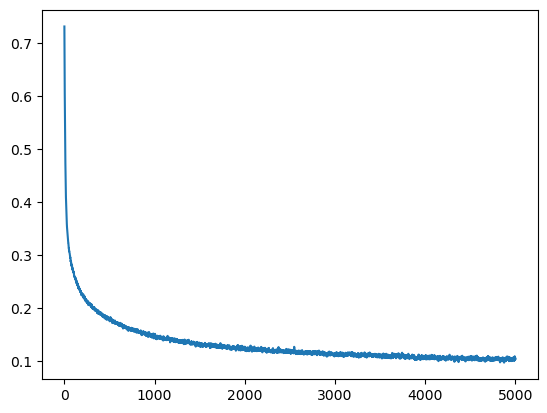

In [7]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []
for epoch in tqdm(range(epochs)):

    total_loss = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss / len(data_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}")

torch.save(model.state_dict(), "models/hv_classifier.pt")
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       0.95      0.85      0.90       988
   Self-direction: thought       0.94      0.88      0.91      1395
    Self-direction: action       0.84      0.19      0.32       247
               Stimulation       0.86      0.25      0.39       172
                  Hedonism       0.94      0.88      0.91      1512
               Achievement       0.93      0.62      0.74       610
          Power: dominance       0.94      0.82      0.88       625
          Power: resources       0.92      0.29      0.44       382
                      Face       0.95      0.81      0.88      2000
        Security: personal       0.94      0.90      0.92      1728
        Security: societal       0.93      0.74      0.83       568
                 Tradition       0.92      0.78      0.84      1177
         Conformity: rules       0.90      0.55      0.68       207
 Conformity: interpersonal       0.91      0.56

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
